In [2]:
import pandas as pd
import numpy as np

from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import monotonically_increasing_id,udf
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")

import constant
import tools

# Load Data

In [8]:
def _load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def _load_weather_toPandas(path, schema:StructType = None):
    """
    load apache parquet file
    """
    weather = _load_parquet(path) \
                    .withColumnRenamed("__index_level_0__", "TIME") \
                    .dropna() \
                    .withColumn("id", monotonically_increasing_id())
    weather.createOrReplaceTempView("weather_temp")
    weather_dic = spark.sql("select * from weather_temp where id in (select max(id) as id from weather_temp group by TIME)").toPandas()
    return weather_dic

def _load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    return sqlContext.read.csv(path, sep=",", header=True, schema=schema)


def load_files():
    windmill = _load_csv(constant.windmill_path, constant.windmills_schema)
    windmill = windmill.where("grid != 0").fillna(0.1)
    return windmill

# Analysis

In [9]:
# initialise sparkContext\
spark = SparkSession.builder \
        .appName("WindTurbine_ws") \
        .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

## Windmills

In [10]:
udic={}
udic["type"] = udf(lambda x: {"H": 1.0, "W": 2.0, "P": 3.0, "M": 4.0}.get(x, 0.0), FloatType())
udic["placement"] = udf(lambda x: {"LAND": 1.0, "HAV": 2.0}.get(x, 0.0), FloatType())

In [11]:
windmill = load_files()
windmill = windmill.withColumn("Turbine_type", udic["type"](windmill.Turbine_type)) \
                .withColumn("Placement", udic["placement"](windmill.Placement))
windmill.persist()
windmill.printSchema()

root
 |-- GSRN: string (nullable = true)
 |-- Turbine_type: float (nullable = true)
 |-- Parent_GSRN: string (nullable = true)
 |-- BBR_municipal: string (nullable = true)
 |-- Placement: float (nullable = true)
 |-- UTM_x: string (nullable = true)
 |-- UTM_y: string (nullable = true)
 |-- Capacity_kw: float (nullable = false)
 |-- Rotor_diameter: float (nullable = false)
 |-- Navhub_height: float (nullable = false)
 |-- grid: string (nullable = true)
 |-- grid_in_range: string (nullable = true)
 |-- Land_cover: float (nullable = false)
 |-- Slope: float (nullable = false)
 |-- roughness: float (nullable = false)



# Geo Impact Analysis

In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

In [40]:

def kmeans_optimal(df, cols, k1, k2):
    vec_assembler = VectorAssembler(inputCols=cols, outputCol="features")
    dfk = vec_assembler.transform(df)

    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
    scalerModel = scaler.fit(dfk)
    dfk = scalerModel.transform(dfk)

    cost = []
    clusters = []

    for k in range(k1, k2):
        kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=5)
        model = kmeans.fit(dfk)
        cost.append(model.computeCost(dfk))
        clusters.append(k)

    # Plot the cost
    df_cost = pd.DataFrame(cost)
    df_cost.columns = ["cost"]
    df_cost.insert(0, 'cluster', clusters)

    return df_cost

In [36]:
import pylab as pl
def elbow_plot(df):
    pl.figure(figsize=(10,6))
    pl.plot(df.cluster, df.cost)
    pl.xticks(range(min(df.cluster), max(df.cluster)))
    pl.xlabel('Number of Clusters')
    pl.ylabel('Score')
    pl.title('Elbow Curve')
    pl.show()

# Kmeans
## Clustering of windmills without Geodata

In [12]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster.elbow import kelbow_visualizer

In [24]:
windmill_pd = windmill.toPandas()

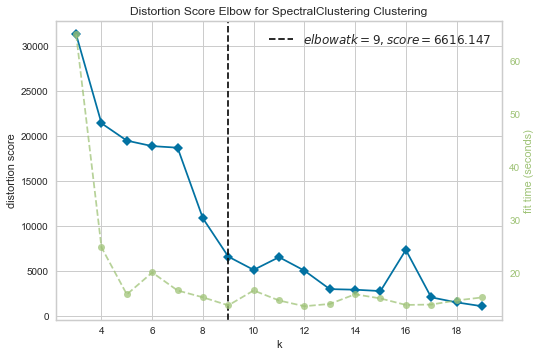

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x121790510>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [28]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height"]
windmill_pd1 = windmill_pd[feat_cols]
windmill_pd1 = StandardScaler().fit_transform(windmill_pd1)
# Instantiate the clustering model and visualizer
kelbow_visualizer(SpectralClustering(random_state=3, assign_labels='discretize'), windmill_pd1, k=(3,20))

## Clustering of windmills with Geodata

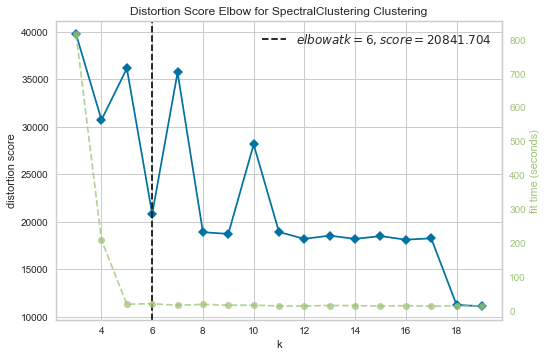

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x117c54dd0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [29]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "roughness"]
windmill_pd2 = windmill_pd[feat_cols]
windmill_pd2 = StandardScaler().fit_transform(windmill_pd2)
# Instantiate the clustering model and visualizer
kelbow_visualizer(SpectralClustering(random_state=3), windmill_pd2, k=(3,20))

# Meanshift
## Without Geo

In [11]:
windmill_pd = pd.read_csv('data/windmill_cleaned.csv')

In [12]:
type_udf = lambda x: {"H": 1.0, "W": 2.0, "P": 3.0, "M": 4.0}.get(x, 0.0)
placement_udf = lambda x: {"LAND": 1.0, "HAV": 2.0}.get(x, 0.0)

In [13]:
windmill_pd['Turbine_type'] = windmill_pd['Turbine_type'].apply(type_udf)
windmill_pd['Placement'] = windmill_pd['Placement'].apply(type_udf)

In [17]:
windmill_pd

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,grid,grid_in_range,Land_cover,Slope,roughness
0,570714700000000027,4.0,5.707147e+17,101.0,0.0,720898.353000,6171174.877,225.0,27.0,30.0,653,"651,693,610,736,695,737,611,653,694,654,652,69...",210.0,3.646971,0.0
1,570714700000000034,4.0,5.707147e+17,101.0,0.0,720993.352000,6171226.877,225.0,27.0,30.0,653,"651,693,610,736,695,737,611,653,694,654,652,69...",100.0,1.012750,1.5
2,570714700000000041,4.0,5.707147e+17,101.0,0.0,727504.304000,6178385.864,600.0,44.0,50.0,653,"651,693,610,695,737,611,653,694,654,652,696,60...",210.0,8.111279,0.0
3,570714700000000058,4.0,5.707147e+17,101.0,0.0,727628.303000,6178385.865,600.0,44.0,50.0,653,"651,693,610,695,737,611,653,694,654,652,696,60...",210.0,5.051153,0.0
4,570714700000000065,4.0,5.707147e+17,101.0,0.0,727817.302000,6178365.866,600.0,44.0,50.0,653,"651,693,610,695,611,653,694,654,652,696,609,65...",210.0,5.885129,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,570715000000055638,3.0,NaN,NaN,0.0,504163.000000,6277061.000,NaN,NaN,NaN,1243,"1283,1241,1326,1285,1284,1199,1158,1242,1202,1...",70.0,2.263636,1.5
9978,570715000000056017,3.0,NaN,NaN,0.0,468672.240000,6145816.035,NaN,NaN,NaN,1235,"1233,1191,1275,1195,1318,1276,1235,1192,1150,1...",10.0,0.000000,0.1
9979,570715000000056857,3.0,NaN,NaN,0.0,513111.100000,6320199.400,NaN,NaN,NaN,1246,"1202,1244,1330,1331,1329,1245,1328,1286,1246,1...",130.0,1.432096,0.1
9980,570715000000056918,3.0,NaN,NaN,0.0,514683.070000,6320302.490,NaN,NaN,NaN,1246,"1202,1244,1330,1331,1329,1245,1328,1286,1246,1...",130.0,0.000000,0.1


In [15]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [16]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height"]
windmill_pd1 = windmill_pd[feat_cols]
windmill_pd1 = StandardScaler().fit_transform(windmill_pd1)

sc = MeanShift()
clusters = sc.fit_predict(windmill_pd1)

silhouette_avg = silhouette_score(windmill_pd1, clusters)
print(silhouette_avg)
print(np.unique(clusters))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## With Geo

In [20]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "roughness"]
windmill_pd2 = windmill_pd[feat_cols]
windmill_pd2 = StandardScaler().fit_transform(windmill_pd2)

sc = MeanShift()
clusters = sc.fit_predict(windmill_pd2)

silhouette_avg = silhouette_score(windmill_pd2, clusters)
print(silhouette_avg)
print(np.unique(clusters))

0.47552347
[ 0  1  2  3  4  5  6  7  8  9 10 11]


# SpectralClustering
## Without

In [31]:
windmill_pd = windmill.toPandas()

In [32]:
windmill_pd.head(3)

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,grid,grid_in_range,Land_cover,Slope,roughness
0,570714700000000027,4.0,5.707147000000504e+17,101.0,1.0,720898.353,6171174.877,225.0,27.0,30.0,653,"651,693,610,736,695,737,611,653,694,654,652,69...",210.0,3.646971,0.0
1,570714700000000034,4.0,5.707147000000504e+17,101.0,1.0,720993.3520000001,6171226.877,225.0,27.0,30.0,653,"651,693,610,736,695,737,611,653,694,654,652,69...",100.0,1.012750,1.5
2,570714700000000041,4.0,5.707147000000505e+17,101.0,1.0,727504.304,6178385.864,600.0,44.0,50.0,653,"651,693,610,695,737,611,653,694,654,652,696,60...",210.0,8.111279,0.0


In [30]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [34]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height"]
windmill_pd1 = windmill_pd[feat_cols]
windmill_pd1 = StandardScaler().fit_transform(windmill_pd1)

for k in range(5,15):
    sc = SpectralClustering(n_clusters=k,random_state=1,n_init=10)
    clusters = sc.fit_predict(windmill_pd1)

    silhouette_avg = silhouette_score(windmill_pd1, clusters)
    print(k, silhouette_avg)

3 0.88446885
4 0.8852001
5 0.5751596
6 0.5279384
7 0.52817833
8 0.5269762
9 0.51820576
10 0.52685106
11 0.5267974
12 0.52475023
13 0.41345397
14 0.51803577
15 0.4198797
16 0.4203953
17 0.4520572
18 0.3607991
19 0.3607856


# SpectralClustering
## With

In [36]:
feat_cols = ["Turbine_type", "Placement", "Capacity_kw", "Rotor_diameter", "Navhub_height", "roughness"]
windmill_pd1 = windmill_pd[feat_cols]
windmill_pd1 = StandardScaler().fit_transform(windmill_pd1)

for k in range(5,15):
    sc = SpectralClustering(n_clusters=k,random_state=1,n_init=10)
    clusters = sc.fit_predict(windmill_pd1)

    silhouette_avg = silhouette_score(windmill_pd1, clusters)
    print(k, silhouette_avg)

3 0.8759142
4 0.87664247


KeyboardInterrupt: 

# Onshore Windmills